 # FashionMNIST

 ## Задание 7.2

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

На практике построим нейронную сеть для классификации картиной. В качестве входных данных используются картинки одежды (в градациях серого, то есть цветовых каналов не 3, а 1). По входной картинке нужно предсказать тип одежды.

In [ ]:
# !pip install torchvision

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision

# -------------------------------
from torch.autograd import Variable
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import torch.nn.functional as F

Скачаем обучающую и контрольную выборки.

In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Normalize((0.1307,), (0.3081,))])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = {
  0: "T-shirt/top",
  1: "Trouser",
  2: "Pullover",
  3: "Dress",
  4: "Coat", 
  5: "Sandal", 
  6: "Shirt",
  7: "Sneaker",
  8: "Bag",
  9: "Ankle boot"
}

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Каждая картинка имеет класс от 0 до 9, расшифровка меток класса:  

|class_id|class_name|
|----|----|
|0| T-shirt/top|
|1| Trouser|
|2| Pullover|
|3| Dress|
|4| Coat|
|5| Sandal|
|6| Shirt|
|7| Sneaker|
|8| Bag|
|9| Ankle boot| 

<h2 style="text-align: center;"><b>Задание</b></h2>

Посмотрите на датасет.
* Сколько картинок в train? В test?
* Равномерно ли распределено количество объектов разных классов в train датасете (это можно понять, поработав с полем `train_data` у переменной `trainset`)? в test?
* Выведите несколько картинок с помощью `pyplot`

Используя материалы семинаров по многослойным  и свёрточным сетям, напишите:
1.  Многослойную нейронную сеть MLP (Multi-Layer Perceptron) классифицирующую этот датасет
2. Свёрточную сеть, классифицирующую этот датасет
3. Сравните их качество (по графикам лосса и по Accuracy Score)

Если качество, которое получается у  нейросети, выше 95%, то Вы решили задачу с точностью, которую можно использовать в жизни.

Количество картинок train = 60000
Количество картинок в test = 10000

Количество объектов разных классов в train датасете распределено равномерно
Количество объектов разных классов в test датасете распределено равномерно

Примеры картинок:
Ankle boot


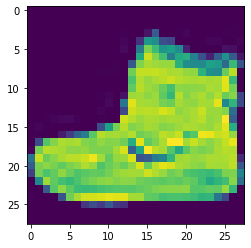


T-shirt/top


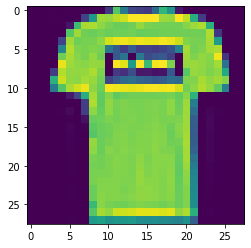


T-shirt/top


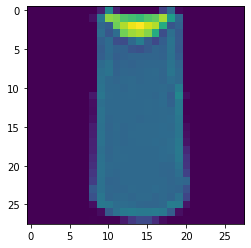

In [ ]:
'''Первая часть'''
# 1 ----------------------------------------------------------------------------
print(f'Количество картинок train = {len(trainset)}')
print(f'Количество картинок в test = {len(testset)}\n')

# 2 ----------------------------------------------------------------------------
trainset_unique = trainset.targets.unique(return_counts=True)[1]
testset_unique = testset.targets.unique(return_counts=True)[1]

print('Количество объектов разных классов в train датасете распределено', end=' ')
if (torch.mean(trainset_unique[0].float()) == trainset_unique[0]).item():
  print('равномерно')
else:
  print('неравномерно')

print('Количество объектов разных классов в test датасете распределено', end=' ')
if (torch.mean(testset_unique[0].float()) == testset_unique[0]).item():
  print('равномерно\n')
else:
  print('неравномерно\n')

# 3 ----------------------------------------------------------------------------
print('Примеры картинок:')
for i in (0, 1, 2):
  print(classes[trainset.targets[i].item()])
  plt.imshow(trainset.data[i])
  plt.show()
  print()

In [ ]:
class MLP(torch.nn.Module):
  # D_in - размерность входа (количество признаков у объекта);
  # H - размерность скрытых слоёв; 
  # D_out - размерность выходного слоя (суть - количество классов)
  def __init__(self, D_in, H, D_out = 10):
    super(MLP, self).__init__()
    self.first_layer = torch.nn.Linear(D_in, H[0])
    self.first_ReLu = torch.nn.ReLU()
    self.second_layer = torch.nn.Linear(H[0], H[1])
    self.second_ReLu = torch.nn.ReLU()
    self.third_layer = torch.nn.Linear(H[1], D_out)
  
  def forward(self, x):
    x = x.view(-1, 784)
    x = self.first_layer(x)
    x = self.first_ReLu(x)
    x = self.second_layer(x)
    x = self.second_ReLu(x)
    x = self.third_layer(x)
    return x

  def fit(self, optimizer, loss_fn, epochs = 5):
    loss_values = []
    for epoch in range(epochs):
      for i, (images, labels) in enumerate(trainloader):
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())
        optimizer.zero_grad()
        loss = loss_fn(self(images), labels)
        loss.backward()
        optimizer.step()
        if(i == 1000):
          loss_values.append(loss.detach().cpu().item())
    plt.plot(loss_values)
    plt.show()
  
  def make_report(self, testloader):  
    model.eval()
    y_trues = list()
    y_hats = list()
    with torch.no_grad():
      for batch in testloader:
        y_pred = self(batch[0].cuda())
        y_hat = torch.argmax(y_pred, dim=1).detach().cpu()
        y_trues.extend(batch[1])
        y_hats.extend(y_hat)
    return classification_report(y_hats, y_trues)

In [ ]:
model = MLP(28**2, (256, 128))

model.cuda()
model.train()

for parameter in model.parameters():
  parameter.requires_grad = True

loss_fn = torch.nn.CrossEntropyLoss(size_average=False)
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


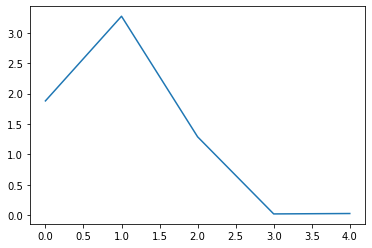

              precision    recall  f1-score   support

           0       0.90      0.79      0.84      1134
           1       0.97      0.99      0.98       979
           2       0.80      0.82      0.81       972
           3       0.88      0.89      0.89       989
           4       0.82      0.80      0.81      1027
           5       0.96      0.97      0.96       993
           6       0.66      0.74      0.70       895
           7       0.93      0.95      0.94       974
           8       0.97      0.97      0.97      1000
           9       0.97      0.94      0.95      1037

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [ ]:
model.fit(optimizer, loss_fn)
print(model.make_report(testloader))

In [ ]:
class CNN(torch.nn.Module):
  # D_in - размерность входа (количество признаков у объекта);
  # H - размерность скрытых слоёв; 
  # D_out - размерность выходного слоя (суть - количество классов)
  def __init__(self, D_in, H, D_out=10):
    super(CNN, self).__init__()
    self.first_conv = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
    self.second_conv = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
    self.first_layer = torch.nn.Linear(D_in, H[0])
    self.second_layer = torch.nn.Linear(H[0], H[1])
    self.third_layer = torch.nn.Linear(H[1], D_out)
  
  def forward(self, x):
    x = self.pool(F.relu(self.first_conv(x)))
    x = self.pool(F.relu(self.second_conv(x)))
    # print(x.shape)
    x = x.view(-1, 16 * 4 * 4)
    x = F.relu(self.first_layer(x))
    x = F.relu(self.second_layer(x))
    x = self.third_layer(x)
    return x

  def fit(self, optimizer, loss_fn, epochs = 10):
    loss_values = []
    for epoch in range(epochs):
      for i, (images, labels) in enumerate(trainloader):
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())
        # зануляем градиенты (чтобы не было остатка с редыдущего шага)
        optimizer.zero_grad()
        # loss
        loss = loss_fn(self(images), labels)
        # backward
        loss.backward()
        # обновляем
        optimizer.step()
        if(i == 1000):
          loss_values.append(loss.detach().cpu().item())
    plt.plot(loss_values)
    plt.show()
  
  def make_report(self, testloader):  
    model.eval()
    y_trues = list()
    y_hats = list()
    with torch.no_grad():
      for batch in testloader:
        y_pred = self(batch[0].cuda())
        y_hat = torch.argmax(y_pred, dim=1).detach().cpu()
        y_trues.extend(batch[1])
        y_hats.extend(y_hat)
    return classification_report(y_hats, y_trues)

In [ ]:
model = CNN(256, (256, 128))

model.cuda()
model.train()

for parameter in model.parameters():
  parameter.requires_grad = True

loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

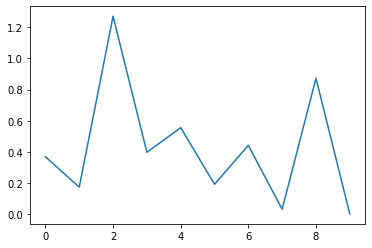

              precision    recall  f1-score   support

           0       0.88      0.83      0.85      1059
           1       0.98      0.99      0.99       981
           2       0.87      0.81      0.84      1078
           3       0.95      0.84      0.89      1127
           4       0.76      0.87      0.81       872
           5       0.98      0.95      0.96      1040
           6       0.66      0.77      0.71       863
           7       0.93      0.96      0.95       973
           8       0.98      0.97      0.97      1010
           9       0.96      0.97      0.97       997

    accuracy                           0.90     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.90      0.90     10000



In [ ]:
import warnings
warnings.filterwarnings('ignore')

model.fit(optimizer, loss_fn)
print(model.make_report(testloader))

## Вывод
Были протестированны CNN и MLP с методом оптимизации Adam. Оба показали примерно одинаковые хорошие результаты с точностью 88-89%. Однако функция потерь лучше убывает у MLP. На графике нет так много скачков, как у CNN. Возможно этих скачков можно избежать, если лучше подобрать гиперпараметры модели.